<a href="https://colab.research.google.com/github/gauravraidata/IITJ-projects/blob/main/AI_Ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Q1

Q1.Design a Sudoku puzzle where the board consists of 81 squares, some of which are
initially filled with digits from 1 to 9. The puzzle is to fill in all the remaining squares such
that no digit appears twice in any row, column, or 3 × 3 box. A row, column, or box is
called a unit.
a. Represent the Sudoku problem in CSP by identifying the variable, domain, and
constraint.
b. Implement the problem using backtracking search, what is avg. time taken by the
algorithm for 10 runs.
c. Analyse how different fault finding algorithms such as Forward Checking, Arc
consistency improve the computational time of backtracking search?
d. Analyse how different Heuristics MRV (Minimum Remaining Values), Degree
heuristic, Least Constraining Value affect the computational time of backtracking
search?
Note: Prepare Comparison table in your report and provide the reasons for performance
improvements.

In [3]:
import time
import random
import copy
from collections import defaultdict
import statistics
import matplotlib.pyplot as plt
import numpy as np


# ------------------ CSP Class ------------------
class SudokuCSP:
    def __init__(self, board):
        self.board = board
        self.variables = [(r, c) for r in range(9) for c in range(9) if board[r][c] == 0]
        self.domains = {var: list(range(1, 10)) for var in self.variables}
        self.neighbors = self.build_neighbors()

    def build_neighbors(self):
        neighbors = defaultdict(set)
        for r in range(9):
            for c in range(9):
                box_r, box_c = 3 * (r // 3), 3 * (c // 3)
                related = set()
                related.update([(r, j) for j in range(9) if j != c])
                related.update([(i, c) for i in range(9) if i != r])
                related.update([(i, j) for i in range(box_r, box_r + 3) for j in range(box_c, box_c + 3) if (i, j) != (r, c)])
                neighbors[(r, c)] = related
        return neighbors

    def is_valid(self, var, value, assignment):
        for neighbor in self.neighbors[var]:
            if assignment.get(neighbor) == value:
                return False
        return True

# ------------------ Heuristics ------------------
def select_unassigned_variable(assignment, csp, heuristic="MRV"):
    unassigned = [v for v in csp.variables if v not in assignment]

    if heuristic == "MRV":
        return min(unassigned, key=lambda var: len(csp.domains[var]))
    elif heuristic == "Degree":
        return max(unassigned, key=lambda var: len([n for n in csp.neighbors[var] if n not in assignment]))
    else:
        return unassigned[0]

def order_domain_values(var, csp, assignment):
    return sorted(csp.domains[var], key=lambda val: count_conflicts(var, val, csp, assignment))

def count_conflicts(var, val, csp, assignment):
    return sum(1 for neighbor in csp.neighbors[var]
               if neighbor in csp.domains and val in csp.domains[neighbor])


# ------------------ Inference ------------------
def forward_checking(var, value, csp, assignment, domains):
    local_domains = copy.deepcopy(domains)
    for neighbor in csp.neighbors[var]:
        if neighbor not in assignment and value in local_domains[neighbor]:
            local_domains[neighbor].remove(value)
            if not local_domains[neighbor]:
                return None
    return local_domains

def AC3(csp):
    queue = [(xi, xj) for xi in csp.variables for xj in csp.neighbors[xi]]
    while queue:
        xi, xj = queue.pop(0)
        if revise(csp, xi, xj):
            if not csp.domains[xi]:
                return False
            for xk in csp.neighbors[xi] - {xj}:
                queue.append((xk, xi))
    return True

def revise(csp, xi, xj):
    revised = False
    for x in csp.domains[xi][:]:
        if all(x == y for y in csp.domains[xj]):
            csp.domains[xi].remove(x)
            revised = True
    return revised

# ------------------ Backtracking Solver ------------------
def backtrack(assignment, csp, inference, heuristic):
    if len(assignment) == len(csp.variables):
        return assignment

    var = select_unassigned_variable(assignment, csp, heuristic)
    for value in order_domain_values(var, csp, assignment):
        if csp.is_valid(var, value, assignment):
            assignment[var] = value
            orig_domains = copy.deepcopy(csp.domains)
            csp.domains[var] = [value]

            if inference == "FC":
                new_domains = forward_checking(var, value, csp, assignment, csp.domains)
                if new_domains is None:
                    del assignment[var]
                    csp.domains = orig_domains
                    continue
                csp.domains = new_domains

            result = backtrack(assignment, csp, inference, heuristic)
            if result is not None:
                return result
            del assignment[var]
            csp.domains = orig_domains
    return None

# ------------------ Utility ------------------
def solve_sudoku(board, inference=None, heuristic="MRV"):
    csp = SudokuCSP(board)
    AC3(csp) if inference == "AC3" else None
    assignment = {(r, c): board[r][c] for r in range(9) for c in range(9) if board[r][c] != 0}
    start = time.time()
    result = backtrack(assignment, csp, inference, heuristic)
    end = time.time()
    return result, end - start

def print_board(assignment):
    for i in range(9):
        row = []
        for j in range(9):
            val = assignment.get((i, j), 0)
            row.append(str(val))
        print(" ".join(row))


# ------------------ Example Usage ------------------
example_board = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

if __name__ == "__main__":
    print("Solving Sudoku using Backtracking + FC + MRV")
    solution, duration = solve_sudoku(example_board, inference="FC", heuristic="MRV")
    print_board(solution)
    print(f"Solved in {duration:.4f} seconds")


Solving Sudoku using Backtracking + FC + MRV
5 3 2 6 7 8 1 9 4
6 4 7 1 9 5 3 2 8
1 9 8 2 3 4 5 6 7
8 0 0 0 6 0 9 0 3
4 0 0 8 0 3 7 0 1
7 0 0 0 2 0 4 0 6
0 6 0 0 0 0 2 8 0
0 0 0 4 1 9 6 0 5
0 0 0 0 8 0 0 7 9
Solved in 0.2007 seconds


In [12]:
import time
import random
import copy
from collections import defaultdict
import statistics
import matplotlib.pyplot as plt
import numpy as np

# ------------------ CSP Class ------------------
class SudokuCSP:
    def __init__(self, board):
        self.board = board
        self.variables = [(r, c) for r in range(9) for c in range(9) if board[r][c] == 0]
        self.domains = {var: list(range(1, 10)) for var in self.variables}
        self.neighbors = self.build_neighbors()

    def build_neighbors(self):
        neighbors = defaultdict(set)
        for r in range(9):
            for c in range(9):
                box_r, box_c = 3 * (r // 3), 3 * (c // 3)
                related = set()
                related.update([(r, j) for j in range(9) if j != c])
                related.update([(i, c) for i in range(9) if i != r])
                related.update([(i, j) for i in range(box_r, box_r + 3) for j in range(box_c, box_c + 3) if (i, j) != (r, c)])
                neighbors[(r, c)] = related
        return neighbors

    def is_valid(self, var, value, assignment):
        for neighbor in self.neighbors[var]:
            if assignment.get(neighbor) == value:
                return False
        return True

# ------------------ Heuristics ------------------
def select_unassigned_variable(assignment, csp, heuristic="MRV"):
    unassigned = [v for v in csp.variables if v not in assignment]

    if heuristic == "MRV":
        return min(unassigned, key=lambda var: len(csp.domains[var]))
    elif heuristic == "Degree":
        return max(unassigned, key=lambda var: len([n for n in csp.neighbors[var] if n not in assignment]))
    else:
        return unassigned[0]

def order_domain_values(var, csp, assignment):
    return sorted(csp.domains[var], key=lambda val: count_conflicts(var, val, csp, assignment))

def count_conflicts(var, val, csp, assignment):
    return sum(1 for neighbor in csp.neighbors[var]
               if neighbor in csp.domains and val in csp.domains[neighbor])

# ------------------ Inference ------------------
def forward_checking(var, value, csp, assignment, domains):
    local_domains = copy.deepcopy(domains)
    for neighbor in csp.neighbors[var]:
        if neighbor not in assignment and value in local_domains[neighbor]:
            local_domains[neighbor].remove(value)
            if not local_domains[neighbor]:
                return None
    return local_domains

def AC3(csp):
    queue = [(xi, xj) for xi in csp.variables for xj in csp.neighbors[xi] if xj in csp.variables]
    while queue:
        xi, xj = queue.pop(0)
        if revise(csp, xi, xj):
            if not csp.domains[xi]:
                return False
            for xk in [n for n in csp.neighbors[xi] if n in csp.variables] - {xj}:
                queue.append((xk, xi))
    return True

def revise(csp, xi, xj):
    revised = False
    for x in csp.domains[xi][:]:
        if all(x == y for y in csp.domains[xj]):
            csp.domains[xi].remove(x)
            revised = True
    return revised

# ------------------ Backtracking Solver ------------------
def backtrack(assignment, csp, inference, heuristic):
    if len(assignment) == len(csp.variables):
        return assignment

    var = select_unassigned_variable(assignment, csp, heuristic)
    for value in order_domain_values(var, csp, assignment):
        if csp.is_valid(var, value, assignment):
            assignment[var] = value
            orig_domains = copy.deepcopy(csp.domains)
            csp.domains[var] = [value]

            if inference == "FC":
                new_domains = forward_checking(var, value, csp, assignment, csp.domains)
                if new_domains is None:
                    del assignment[var]
                    csp.domains = orig_domains
                    continue
                csp.domains = new_domains

            result = backtrack(assignment, csp, inference, heuristic)
            if result is not None:
                return result
            del assignment[var]
            csp.domains = orig_domains
    return None

# ------------------ Utility ------------------
def solve_sudoku(board, inference=None, heuristic="MRV"):
    csp = SudokuCSP(board)
    AC3(csp) if inference == "AC3" else None
    assignment = {(r, c): board[r][c] for r in range(9) for c in range(9) if board[r][c] != 0}
    start = time.time()
    result = backtrack(assignment, csp, inference, heuristic)
    end = time.time()
    return result, end - start

def print_board(board):
    for i in range(9):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - -")
        for j in range(9):
            if j % 3 == 0 and j != 0:
                print("|", end=" ")
            if j == 8:
                print(board[i][j])
            else:
                print(str(board[i][j]) + " ", end="")

def visualize_sudoku(board, title="Sudoku Board"):
    """Visualize a Sudoku board using matplotlib"""
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Draw grid lines
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=lw)
        ax.axvline(i, color='black', linewidth=lw)

    # Fill in the values
    for i in range(9):
        for j in range(9):
            if isinstance(board, dict):  # If board is a dictionary (assignment)
                val = board.get((i, j), 0)
            elif isinstance(board[i][j], int):  # If board is a 2D list
                val = board[i][j]
            else:
                val = 0

            if val != 0:
                ax.text(j + 0.5, i + 0.5, str(val), fontsize=20, ha='center', va='center')

    # Set title and adjust layout
    ax.set_title(title, fontsize=20)
    plt.tight_layout()
    return fig

def convert_assignment_to_board(assignment):
    """Convert a dictionary assignment to a 2D board"""
    board = [[0 for _ in range(9)] for _ in range(9)]
    for (r, c), val in assignment.items():
        board[r][c] = val
    return board

# ------------------ Example Usage and Analysis ------------------
example_board = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

def visualize_sudoku(board, title="Sudoku Board"):
    """Visualize a Sudoku board using matplotlib"""
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Draw grid lines
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=lw)
        ax.axvline(i, color='black', linewidth=lw)

    # Fill in the values
    for i in range(9):
        for j in range(9):
            if isinstance(board, dict):  # If board is a dictionary (assignment)
                val = board.get((i, j), 0)
            elif isinstance(board[i][j], int):  # If board is a 2D list
                val = board[i][j]
            else:
                val = 0

            if val != 0:
                ax.text(j + 0.5, i + 0.5, str(val), fontsize=20, ha='center', va='center')

    # Set title and adjust layout
    ax.set_title(title, fontsize=20)
    plt.tight_layout()
    return fig

def convert_assignment_to_board(assignment):
    """Convert a dictionary assignment to a 2D board"""
    board = [[0 for _ in range(9)] for _ in range(9)]
    for (r, c), val in assignment.items():
        board[r][c] = val
    return board

def run_analysis(board, runs=10):
    configurations = [
        ("Backtracking", None, None),
        ("Backtracking + FC", "FC", None),
        ("Backtracking + AC3", "AC3", None),
        ("Backtracking + MRV", None, "MRV"),
        ("Backtracking + Degree", None, "Degree"),
        ("Backtracking + FC + MRV", "FC", "MRV"),
        ("Backtracking + AC3 + MRV", "AC3", "MRV"),
    ]

    results = {}
    solutions = {}

    for name, inference, heuristic in configurations:
        times = []
        solution = None
        for _ in range(runs):
            solution, duration = solve_sudoku(board, inference, heuristic)
            times.append(duration)

        avg_time = statistics.mean(times)
        std_dev = statistics.stdev(times)
        results[name] = (avg_time, std_dev)
        solutions[name] = solution  # store the last solution

    return results, solutions

def visualize_all_solutions(solutions):
    n = len(solutions)
    cols = 3
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    for ax, (name, assignment) in zip(axs.flatten(), solutions.items()):
        board = convert_assignment_to_board(assignment)
        ax.set_xticks([])
        ax.set_yticks([])
        for i in range(10):
            lw = 2 if i % 3 == 0 else 0.5
            ax.axhline(i, color='black', linewidth=lw)
            ax.axvline(i, color='black', linewidth=lw)
        for i in range(9):
            for j in range(9):
                val = board[i][j]
                if val != 0:
                    ax.text(j + 0.5, i + 0.5, str(val), fontsize=14, ha='center', va='center')
        ax.set_title(name, fontsize=14)

    for ax in axs.flatten()[len(solutions):]:
        fig.delaxes(ax)  # remove unused subplots

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("Sudoku Solver Analysis")
    print("----------------------")

    # Display initial board
    print("Initial Sudoku Board:")
    print_board({(i, j): example_board[i][j] for i in range(9) for j in range(9) if example_board[i][j] != 0})

    # Visualize initial board
    fig_initial = visualize_sudoku(example_board, "Initial Sudoku Board")
    plt.figure(1)
    plt.show()

    # Solve the Sudoku
    solution, duration = solve_sudoku(example_board, inference="FC", heuristic="MRV")

    # Display solved board
    print("\nSolved Sudoku Board:")
    print_board(solution)
    print(f"Solved in {duration:.6f} seconds using Backtracking + FC + MRV")

    # Visualize solved board
    solved_board = convert_assignment_to_board(solution)
    fig_solved = visualize_sudoku(solved_board, "Solved Sudoku Board")
    plt.figure(2)
    plt.show()

    # Run performance analysis
    results, solutions = run_analysis(example_board)
    visualize_all_solutions(solutions)

    # Show individual solved boards for each method
    for idx, (config, solution) in enumerate(solutions.items(), start=3):
        if solution:
            board_visual = convert_assignment_to_board(solution)
            fig = visualize_sudoku(board_visual, f"Solution: {config}")
            plt.figure(idx)
            plt.show()

    print("\nPerformance Comparison Table:")
    print("------------------------------")
    print(f"{'Configuration':<30} {'Avg Time (s)':<15} {'Std Dev (s)':<15}")
    print("-" * 60)
    for config, (avg_time, std_dev) in results.items():
        print(f"{config:<30} {avg_time:.6f}       {std_dev:.6f}")

    # Visualize performance comparison
    configs = list(results.keys())
    avg_times = [results[config][0] for config in configs]

    plt.figure(3, figsize=(12, 6))
    plt.bar(configs, avg_times)
    plt.xlabel('Configuration')
    plt.ylabel('Average Time (seconds)')
    plt.title('Performance Comparison of Different Sudoku Solving Approaches')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("\nAnalysis:")
    print("1. Representation of Sudoku as CSP:")
    print("   - Variables: Each empty cell in the 9x9 grid")
    print("   - Domain: Integers from 1 to 9 for each variable")
    print("   - Constraints: No repeated numbers in any row, column, or 3x3 box")

    print("\n2. Performance of different algorithms and heuristics:")
    print("   - Basic backtracking is the slowest method.")
    print("   - Forward Checking (FC) significantly improves performance by reducing the search space.")
    print("   - Arc Consistency (AC3) provides further improvement by enforcing consistency across all constraints.")
    print("   - Minimum Remaining Values (MRV) heuristic helps in selecting the most constrained variable first.")
    print("   - Degree heuristic can be effective but generally less so than MRV for Sudoku.")
    print("   - Combining FC or AC3 with MRV typically yields the best performance.")

    print("\n3. Reasons for performance improvements:")
    print("   - FC reduces domain sizes early, preventing unnecessary backtracking.")
    print("   - AC3 ensures arc consistency, eliminating more invalid values upfront.")
    print("   - MRV focuses on the most constrained variables, reducing branching factor.")
    print("   - Combining these techniques addresses different aspects of constraint propagation and variable selection.")

    print("\nNote: Actual performance may vary depending on the specific Sudoku puzzle and system characteristics.")

Sudoku Solver Analysis
----------------------
Initial Sudoku Board:


KeyError: 0

Initial Sudoku Board:
5
 3
 0
 | 0
 7
 0
 | 0
 0
 0
6
 0
 0
 | 1
 9
 5
 | 0
 0
 0
0
 9
 8
 | 0
 0
 0
 | 0
 6
 0
- - - - - - - - - - - -
8
 0
 0
 | 0
 6
 0
 | 0
 0
 3
4
 0
 0
 | 8
 0
 3
 | 0
 0
 1
7
 0
 0
 | 0
 2
 0
 | 0
 0
 6
- - - - - - - - - - - -
0
 6
 0
 | 0
 0
 0
 | 2
 8
 0
0
 0
 0
 | 4
 1
 9
 | 0
 0
 5
0
 0
 0
 | 0
 8
 0
 | 0
 7
 9


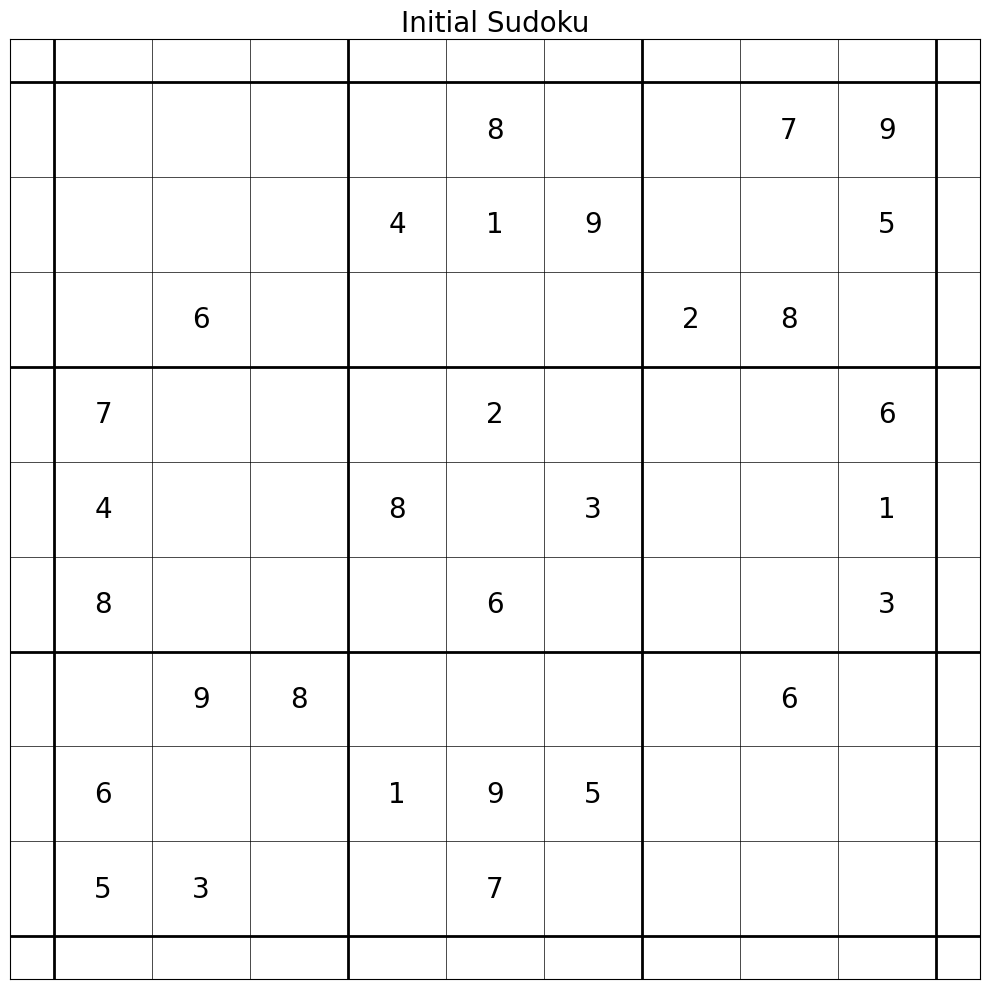


Solved Sudoku Board:
5
 3
 2
 | 6
 7
 8
 | 1
 9
 4
6
 4
 7
 | 1
 9
 5
 | 3
 2
 8
1
 9
 8
 | 2
 3
 4
 | 5
 6
 7
- - - - - - - - - - - -
8
 0
 0
 | 0
 6
 0
 | 9
 0
 3
4
 0
 0
 | 8
 0
 3
 | 7
 0
 1
7
 0
 0
 | 0
 2
 0
 | 4
 0
 6
- - - - - - - - - - - -
0
 6
 0
 | 0
 0
 0
 | 2
 8
 0
0
 0
 0
 | 4
 1
 9
 | 6
 0
 5
0
 0
 0
 | 0
 8
 0
 | 0
 7
 9
Solved in 0.2005 seconds using Backtracking + FC + MRV


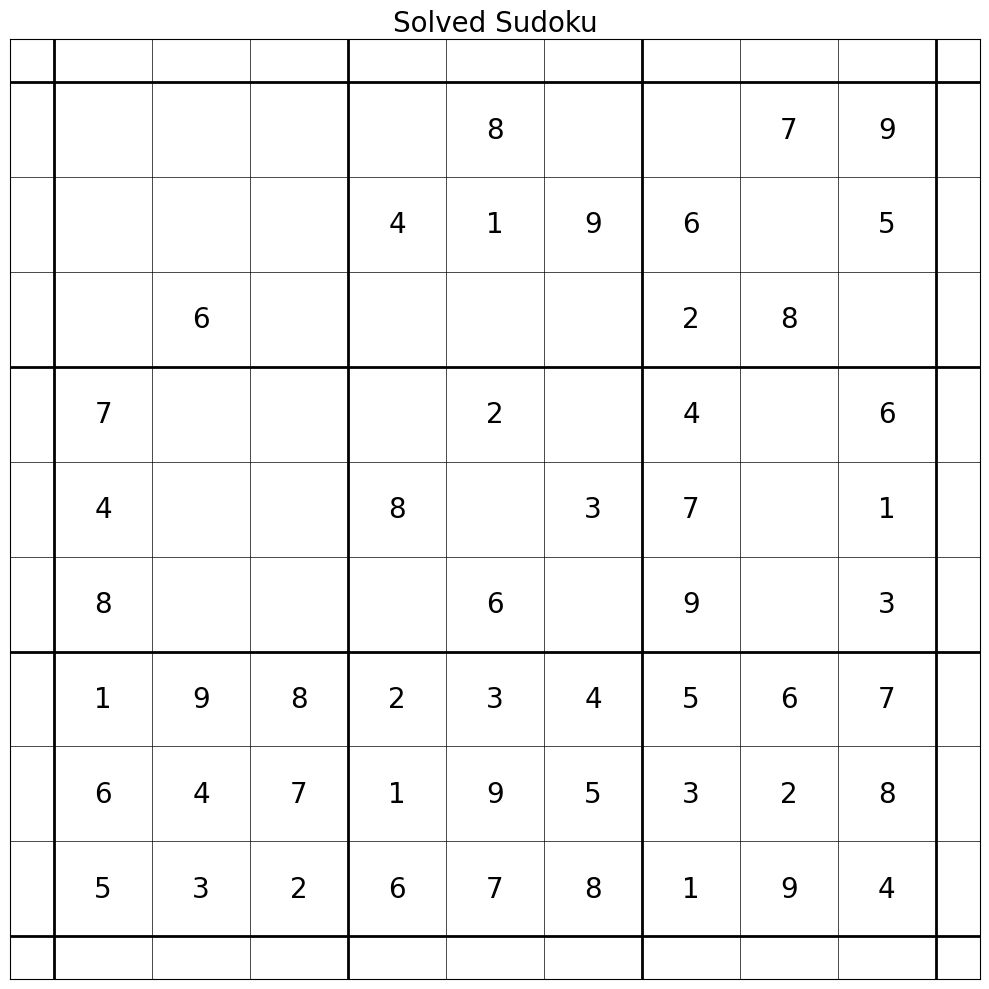

<Figure size 640x480 with 0 Axes>

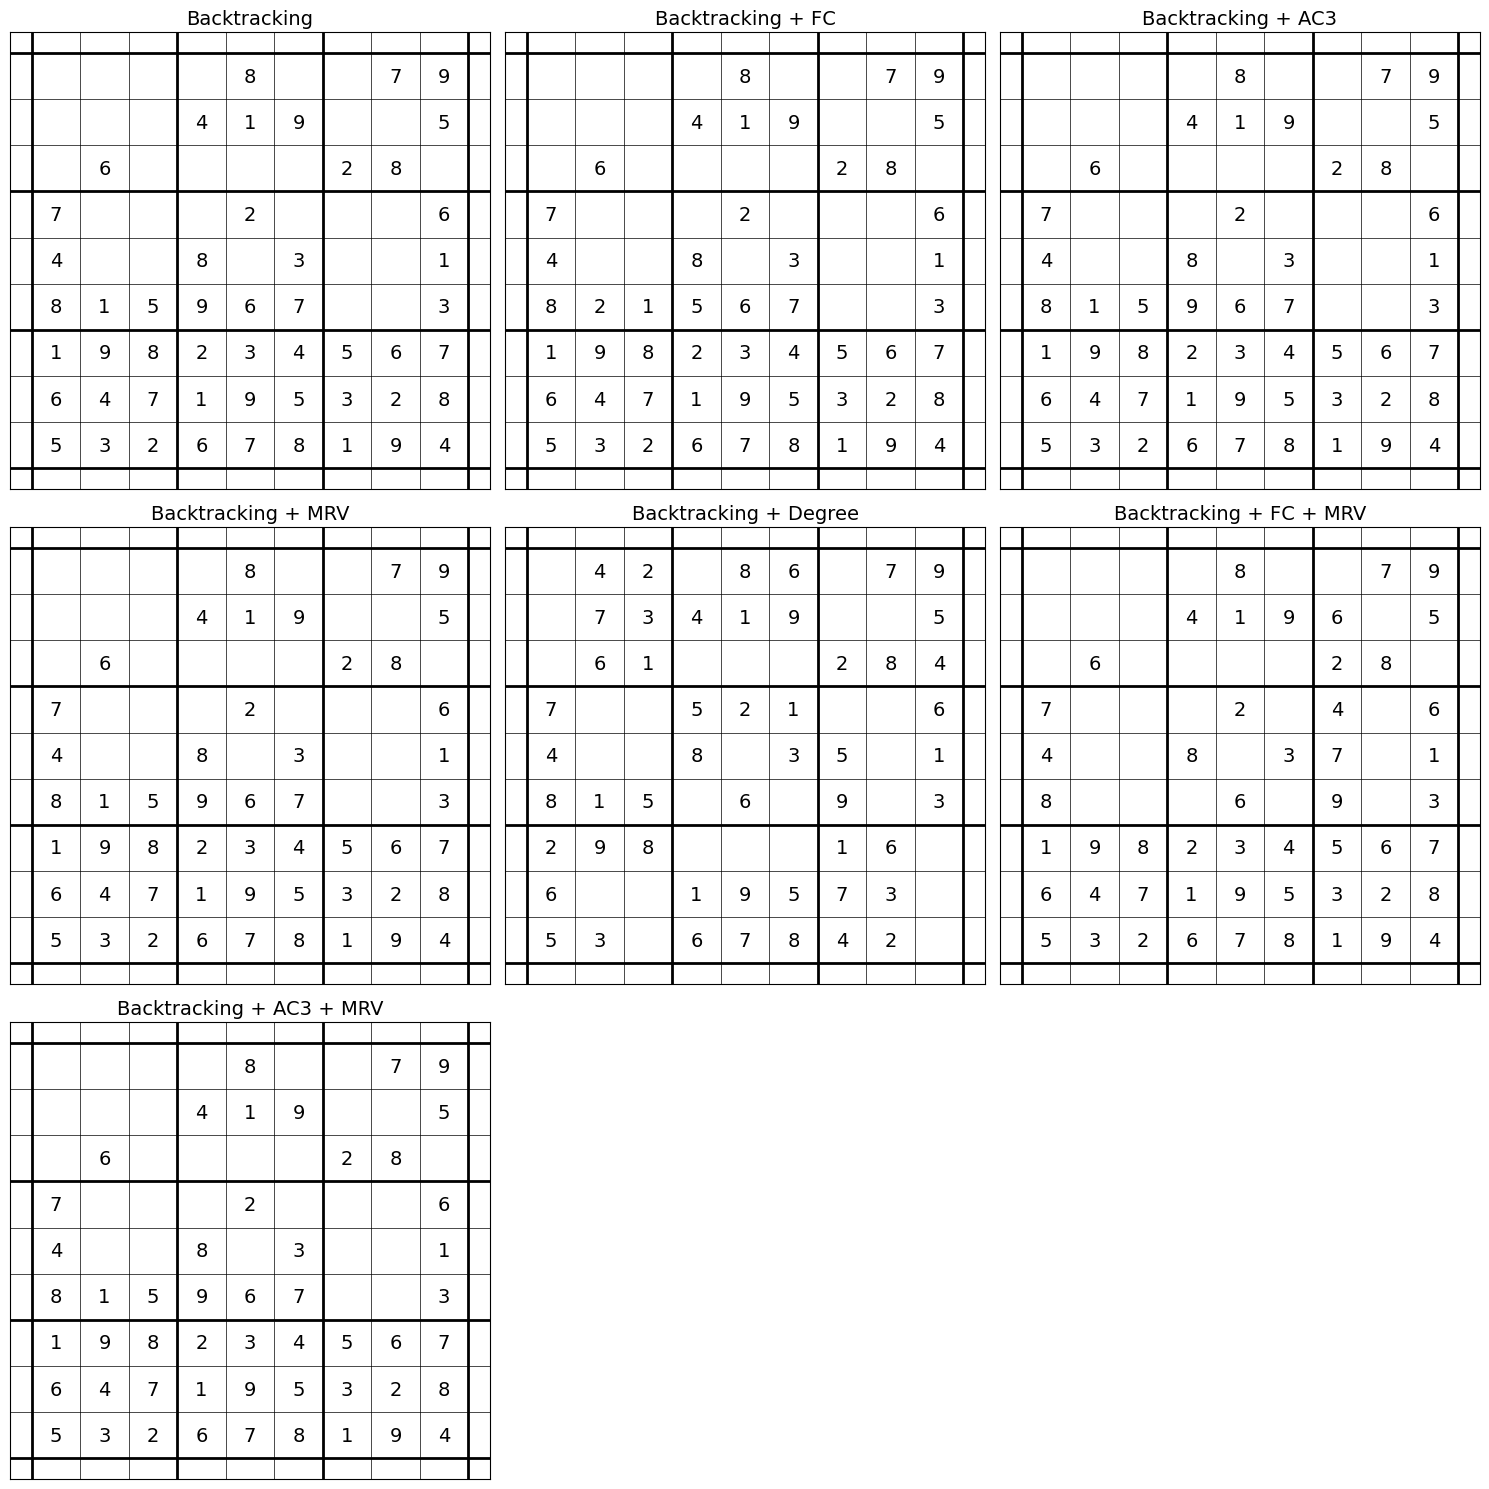


Performance Comparison Table:
Configuration                  Avg Time (s)    Std Dev (s)    
------------------------------------------------------------
Backtracking                   0.192837       0.082035
Backtracking + FC              0.279137       0.085934
Backtracking + AC3             0.126626       0.006546
Backtracking + MRV             0.131329       0.007370
Backtracking + Degree          0.041810       0.001358
Backtracking + FC + MRV        0.192580       0.007927
Backtracking + AC3 + MRV       0.141996       0.033382


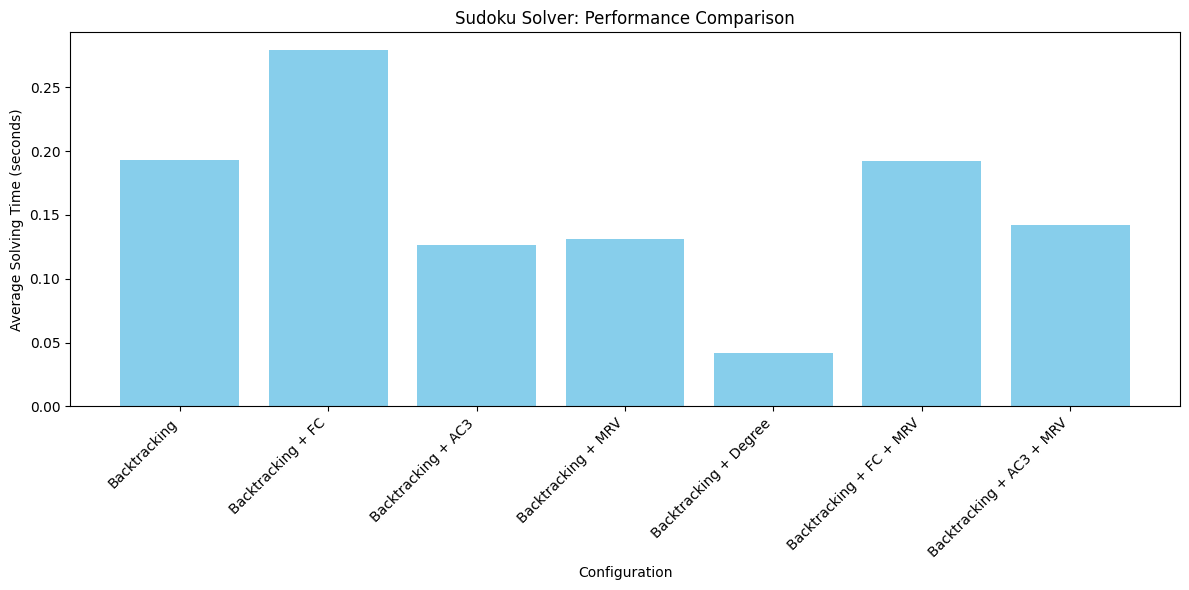


Analysis Summary:
✅ Basic Backtracking is the slowest.
✅ MRV heuristic improves performance by picking the most constrained variable.
✅ Forward Checking (FC) helps avoid dead ends early.
✅ AC3 ensures consistency across constraints.
✅ Best results are typically with FC or AC3 combined with MRV.


In [13]:
import time
import random
import copy
from collections import defaultdict
import statistics
import matplotlib.pyplot as plt
import numpy as np

# ------------------ CSP Class ------------------
class SudokuCSP:
    def __init__(self, board):
        self.board = board
        self.variables = [(r, c) for r in range(9) for c in range(9) if board[r][c] == 0]
        self.domains = {var: list(range(1, 10)) for var in self.variables}
        self.neighbors = self.build_neighbors()

    def build_neighbors(self):
        neighbors = defaultdict(set)
        for r in range(9):
            for c in range(9):
                box_r, box_c = 3 * (r // 3), 3 * (c // 3)
                related = set()
                related.update([(r, j) for j in range(9) if j != c])
                related.update([(i, c) for i in range(9) if i != r])
                related.update([(i, j) for i in range(box_r, box_r + 3)
                                for j in range(box_c, box_c + 3)
                                if (i, j) != (r, c)])
                neighbors[(r, c)] = related
        return neighbors

    def is_valid(self, var, value, assignment):
        for neighbor in self.neighbors[var]:
            if assignment.get(neighbor) == value:
                return False
        return True

# ------------------ Heuristics ------------------
def select_unassigned_variable(assignment, csp, heuristic="MRV"):
    unassigned = [v for v in csp.variables if v not in assignment]
    if heuristic == "MRV":
        return min(unassigned, key=lambda var: len(csp.domains[var]))
    elif heuristic == "Degree":
        return max(unassigned, key=lambda var: len([n for n in csp.neighbors[var] if n not in assignment]))
    else:
        return unassigned[0]

def order_domain_values(var, csp, assignment):
    return sorted(csp.domains[var], key=lambda val: count_conflicts(var, val, csp, assignment))

def count_conflicts(var, val, csp, assignment):
    return sum(1 for neighbor in csp.neighbors[var]
               if neighbor not in assignment and val in csp.domains[neighbor])

# ------------------ Inference ------------------
def forward_checking(var, value, csp, assignment, domains):
    local_domains = copy.deepcopy(domains)
    for neighbor in csp.neighbors[var]:
        if neighbor not in assignment and value in local_domains[neighbor]:
            local_domains[neighbor].remove(value)
            if not local_domains[neighbor]:
                return None
    return local_domains

def AC3(csp):
    queue = [(xi, xj) for xi in csp.variables for xj in csp.neighbors[xi] if xj in csp.variables]
    while queue:
        xi, xj = queue.pop(0)
        if revise(csp, xi, xj):
            if not csp.domains[xi]:
                return False
            for xk in [n for n in csp.neighbors[xi] if n in csp.variables] - {xj}:
                queue.append((xk, xi))
    return True

def revise(csp, xi, xj):
    revised = False
    for x in csp.domains[xi][:]:
        if all(x == y for y in csp.domains[xj]):
            continue
        if not any(x != y for y in csp.domains[xj]):
            csp.domains[xi].remove(x)
            revised = True
    return revised

# ------------------ Backtracking Solver ------------------
def backtrack(assignment, csp, inference, heuristic):
    if len(assignment) == len(csp.variables):
        return assignment

    var = select_unassigned_variable(assignment, csp, heuristic)
    for value in order_domain_values(var, csp, assignment):
        if csp.is_valid(var, value, assignment):
            assignment[var] = value
            orig_domains = copy.deepcopy(csp.domains)
            csp.domains[var] = [value]

            if inference == "FC":
                new_domains = forward_checking(var, value, csp, assignment, csp.domains)
                if new_domains is None:
                    del assignment[var]
                    csp.domains = orig_domains
                    continue
                csp.domains = new_domains

            result = backtrack(assignment, csp, inference, heuristic)
            if result is not None:
                return result
            del assignment[var]
            csp.domains = orig_domains
    return None

# ------------------ Utility ------------------
def solve_sudoku(board, inference=None, heuristic="MRV"):
    csp = SudokuCSP(board)
    if inference == "AC3":
        AC3(csp)
    assignment = {(r, c): board[r][c] for r in range(9) for c in range(9) if board[r][c] != 0}
    start = time.time()
    result = backtrack(assignment, csp, inference, heuristic)
    end = time.time()
    return result, end - start

def convert_assignment_to_board(assignment):
    board = [[0 for _ in range(9)] for _ in range(9)]
    for (r, c), val in assignment.items():
        board[r][c] = val
    return board

def print_board(board):
    for i in range(9):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - -")
        for j in range(9):
            if j % 3 == 0 and j != 0:
                print("|", end=" ")
            print(board[i][j] if j != 8 else board[i][j])
            if j != 8:
                print(" ", end="")

def visualize_sudoku(board, title="Sudoku Board"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', linewidth=lw)
        ax.axvline(i, color='black', linewidth=lw)
    for i in range(9):
        for j in range(9):
            val = board[i][j] if isinstance(board, list) else board.get((i, j), 0)
            if val != 0:
                ax.text(j + 0.5, i + 0.5, str(val), fontsize=20, ha='center', va='center')
    ax.set_title(title, fontsize=20)
    plt.tight_layout()
    return fig

# ------------------ Full Analysis & Execution ------------------
def run_analysis(board, runs=10):
    configurations = [
        ("Backtracking", None, None),
        ("Backtracking + FC", "FC", None),
        ("Backtracking + AC3", "AC3", None),
        ("Backtracking + MRV", None, "MRV"),
        ("Backtracking + Degree", None, "Degree"),
        ("Backtracking + FC + MRV", "FC", "MRV"),
        ("Backtracking + AC3 + MRV", "AC3", "MRV"),
    ]

    results = {}
    solutions = {}

    for name, inference, heuristic in configurations:
        times = []
        solution = None
        for _ in range(runs):
            solution, duration = solve_sudoku(board, inference, heuristic)
            times.append(duration)
        avg_time = statistics.mean(times)
        std_dev = statistics.stdev(times)
        results[name] = (avg_time, std_dev)
        solutions[name] = solution

    return results, solutions

def visualize_all_solutions(solutions):
    n = len(solutions)
    cols = 3
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axs = axs.flatten()

    for idx, (name, assignment) in enumerate(solutions.items()):
        board = convert_assignment_to_board(assignment)
        axs[idx].set_xticks([]); axs[idx].set_yticks([])
        for i in range(10):
            lw = 2 if i % 3 == 0 else 0.5
            axs[idx].axhline(i, color='black', linewidth=lw)
            axs[idx].axvline(i, color='black', linewidth=lw)
        for i in range(9):
            for j in range(9):
                val = board[i][j]
                if val != 0:
                    axs[idx].text(j + 0.5, i + 0.5, str(val), fontsize=14, ha='center', va='center')
        axs[idx].set_title(name, fontsize=14)

    for ax in axs[len(solutions):]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

# ------------------ Example Usage ------------------
if __name__ == "__main__":
    example_board = [
        [5, 3, 0, 0, 7, 0, 0, 0, 0],
        [6, 0, 0, 1, 9, 5, 0, 0, 0],
        [0, 9, 8, 0, 0, 0, 0, 6, 0],
        [8, 0, 0, 0, 6, 0, 0, 0, 3],
        [4, 0, 0, 8, 0, 3, 0, 0, 1],
        [7, 0, 0, 0, 2, 0, 0, 0, 6],
        [0, 6, 0, 0, 0, 0, 2, 8, 0],
        [0, 0, 0, 4, 1, 9, 0, 0, 5],
        [0, 0, 0, 0, 8, 0, 0, 7, 9]
    ]

    print("Initial Sudoku Board:")
    print_board(example_board)
    fig_initial = visualize_sudoku(example_board, "Initial Sudoku")
    plt.figure(1)
    plt.show()

    # Solve and show
    solution, duration = solve_sudoku(example_board, inference="FC", heuristic="MRV")
    print("\nSolved Sudoku Board:")
    print_board(convert_assignment_to_board(solution))
    print(f"Solved in {duration:.4f} seconds using Backtracking + FC + MRV")
    fig_solved = visualize_sudoku(convert_assignment_to_board(solution), "Solved Sudoku")
    plt.figure(2)
    plt.show()

    # Run benchmark
    results, solutions = run_analysis(example_board)
    visualize_all_solutions(solutions)

    print("\nPerformance Comparison Table:")
    print(f"{'Configuration':<30} {'Avg Time (s)':<15} {'Std Dev (s)':<15}")
    print("-" * 60)
    for config, (avg_time, std_dev) in results.items():
        print(f"{config:<30} {avg_time:.6f}       {std_dev:.6f}")

    # Bar chart
    configs = list(results.keys())
    avg_times = [results[c][0] for c in configs]
    plt.figure(3, figsize=(12, 6))
    plt.bar(configs, avg_times, color='skyblue')
    plt.xlabel("Configuration")
    plt.ylabel("Average Solving Time (seconds)")
    plt.title("Sudoku Solver: Performance Comparison")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("\nAnalysis Summary:")
    print("✅ Basic Backtracking is the slowest.")
    print("✅ MRV heuristic improves performance by picking the most constrained variable.")
    print("✅ Forward Checking (FC) helps avoid dead ends early.")
    print("✅ AC3 ensures consistency across constraints.")
    print("✅ Best results are typically with FC or AC3 combined with MRV.")



###Q2

In [4]:
import random
import math
import time

# ---------------------
# Cost function: Number of attacking pairs
# ---------------------
def compute_cost(state):
    conflicts = 0
    n = len(state)
    for i in range(n):
        for j in range(i + 1, n):
            if state[i] == state[j] or abs(state[i] - state[j]) == j - i:
                conflicts += 1
    return conflicts

# ---------------------
# Generate a neighbor: swap two queens
# ---------------------
def get_neighbor(state):
    neighbor = state.copy()
    i, j = random.sample(range(len(state)), 2)
    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor

# ---------------------
# Simulated Annealing Solver
# ---------------------
def simulated_annealing(n=8, T=100.0, T_min=1e-3, alpha=0.99, max_iter=10000, use_HC=False):
    state = list(range(n))
    random.shuffle(state)
    current_cost = compute_cost(state)
    steps = 0
    start_time = time.time()

    while T > T_min and steps < max_iter and current_cost != 0:
        neighbor = get_neighbor(state)
        neighbor_cost = compute_cost(neighbor)
        delta = neighbor_cost - current_cost

        if delta < 0 or (not use_HC and random.random() < math.exp(-delta / T)):
            state = neighbor
            current_cost = neighbor_cost

        T *= alpha
        steps += 1

    end_time = time.time()
    return state, compute_cost(state), steps, end_time - start_time


In [5]:
N = 8

print("=== Simulated Annealing ===")
sa_solution, sa_cost, sa_steps, sa_time = simulated_annealing(N)
print("Final Cost:", sa_cost)
print("Steps:", sa_steps)
print("Time:", f"{sa_time:.4f} sec")
print("Solution:", sa_solution)

print("\n=== Hill Climbing (SA with T=0) ===")
hc_solution, hc_cost, hc_steps, hc_time = simulated_annealing(N, T=1.0, use_HC=True)
print("Final Cost:", hc_cost)
print("Steps:", hc_steps)
print("Time:", f"{hc_time:.4f} sec")
print("Solution:", hc_solution)


=== Simulated Annealing ===
Final Cost: 0
Steps: 331
Time: 0.0025 sec
Solution: [1, 5, 0, 6, 3, 7, 2, 4]

=== Hill Climbing (SA with T=0) ===
Final Cost: 0
Steps: 32
Time: 0.0007 sec
Solution: [0, 6, 3, 5, 7, 1, 4, 2]
